In [21]:
import os

from torch import cuda, device, distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
import importlib
import torch as T
import gymnasium as gym
import os, random
from pathlib import Path

import policygradient
importlib.reload(policygradient)

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.display import clear_output

### Initializing the Environment

In [22]:
env_id = "CartPole-v1"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [-3.4470561e+00  1.7816312e+38 -1.7396741e-01 -2.9512987e+38]


In [23]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

In [41]:
class ActorCritic(nn.Module):
    def __init__(self, s_size, a_size, lyr1, lyr2):
        super(ActorCritic, self).__init__()
        self.s_size = s_size
        self.lyr1 = lyr1
        self.lyr2 = lyr2
        self.a_size = a_size
        self.linear1 = nn.Linear(self.s_size, self.lyr1)
        self.linear2 = nn.Linear(self.lyr1, self.lyr2)
        self.pi = nn.Linear(self.lyr2, a_size)
        self.v = nn.Linear(self.lyr2, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, obs):
        state = T.Tensor(obs)
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        pi = self.pi(x)
        probs =F.softmax(pi,dim = -1)
        v = self.v(x)
        return (probs, v)
    
    def learn(self,s, a, r, s_, done):
        
        self.optimizer.zero_grad()
        
        s = T.FloatTensor(s).to(device)
        s_ = T.FloatTensor(s_).to(device)

        probs, value = agent(s)
        _, value_ = agent(s_)

        delta = r + gamma * value_*(1-int(done)) - value
        actor_loss = -T.log(probs[a]) * delta.item()
        critic_loss = 0.1*delta**2
        (actor_loss + critic_loss).backward()
        self.optimizer.step()
        
        return actor_loss.item(), critic_loss.item()
    
    def save(self, model_file):
        T.save(self.state_dict(), model_file)
        
    def load(self, model_file):
        self.load_state_dict(T.load(model_file))

In [46]:
layer1 = 32
layer2 = 64
gamma = 0.99
learning_rate = 0.0001
episodes = 100_000

# Average window size. The size of the silding window
# used to calculate the mean reward across the last N episodes
# where N is the avg_win_size

avg_win_size = 20
epi_results = deque(maxlen=avg_win_size)
actor_loss_results = deque(maxlen=avg_win_size)
critic_loss_results = deque(maxlen=avg_win_size)

# Initialize Agent
agent = ActorCritic(s_size, a_size, layer1, layer2).to(device)

In [47]:
# model and log file names
log_file_name = os.path.join('.','artefacts',f'{env_id}_actorcritic.csv')
model_file = os.path.join('.','models',f'{env_id}_actorcritic.pth')

In [ ]:
steps = 0
train = True

if train:
    # Delete old trainig log if exists
    if os.path.exists(log_file_name):
        os.remove(log_file_name)

    log_file = open(log_file_name, "w")
    log_file.write(f'episode,rewards,actor_loss,critic_loss\n')

    for epi in range(episodes):

        s = env.reset()[0]
        done, trunc = False, False
        rewards = 0
        while not any([done, trunc]):

            state = T.FloatTensor(s).to(device)
            with T.no_grad():
                p,_ = agent(state)

            p_vals = p.detach().cpu().numpy()
            a = np.random.choice(a_size, p=p_vals)
            s_, r, done ,trunc , _  = env.step(a)

            actor_loss, critic_loss = agent.learn(s, a, r, s_, done)
            actor_loss_results.append(actor_loss)
            critic_loss_results.append(critic_loss) 

            steps += 1
            rewards += r
            s = s_

            if done:
                epi_results.append(rewards)
                break
        
        log_file.write(f'{epi},{np.sum(rewards):.2f},{actor_loss:.4f},{critic_loss:.4f}\n')

        if epi % 10 == 0:
            print(f'{epi = } mean reward : {np.mean(epi_results):.2f} mean actor loss : {np.mean(actor_loss_results):.4f} mean critic loss : {np.mean(critic_loss_results):.4f} steps = {steps}')

        if epi % 100 == 0:
            clear_output()

        if np.mean(epi_results)>=500:
            break

if train:
    print(f'Saving Agent as {model_file}')
    agent.save(model_file)
    log_file.close()

epi = 13510 mean reward : 161.20 mean actor loss : 0.0151 mean critic loss : 0.1005 steps = 2862940
epi = 13520 mean reward : 154.90 mean actor loss : 0.0163 mean critic loss : 0.0659 steps = 2864542
epi = 13530 mean reward : 153.10 mean actor loss : 0.0007 mean critic loss : 0.0204 steps = 2866002
epi = 13540 mean reward : 161.40 mean actor loss : 0.0183 mean critic loss : 0.0351 steps = 2867770
epi = 13550 mean reward : 164.55 mean actor loss : 0.0014 mean critic loss : 0.0803 steps = 2869293
epi = 13560 mean reward : 147.65 mean actor loss : 0.0136 mean critic loss : 0.5051 steps = 2870723


In [49]:
log_file.close()

In [28]:
eval_agent = ActorCritic(s_size, a_size, layer1, layer2).to(device)
eval_agent.load(model_file)
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

Text(0.5, 1.0, 'Loss')

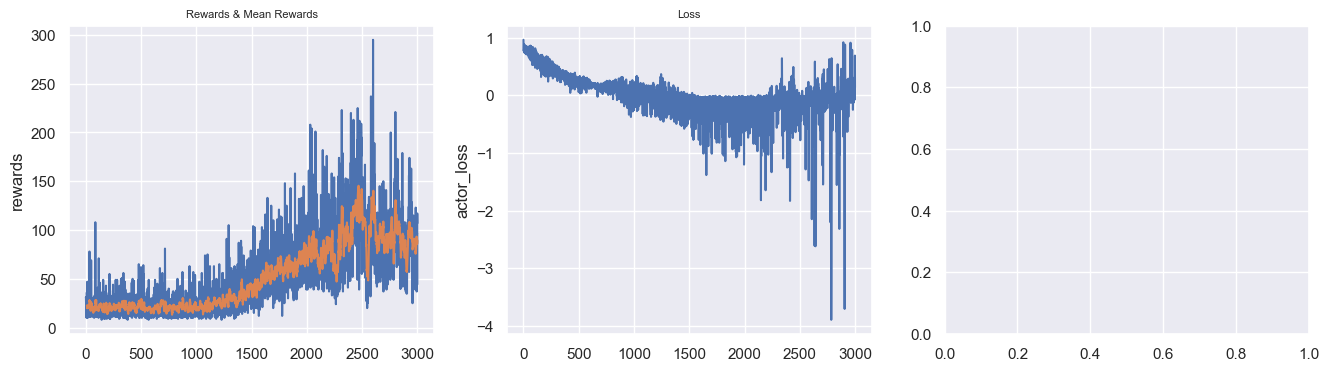

In [29]:

fig,ax=plt.subplots(1,3,sharex='col',sharey= False,figsize=(16,4))

sns.lineplot(df['rewards'], ax = ax[0])
sns.lineplot(df['mean_rewards'],ax = ax[0])
ax[0].set_title('Rewards & Mean Rewards',fontsize=8)

sns.lineplot(df['actor_loss'],ax = ax[1])
ax[1].set_title('Loss',fontsize=8)

In [30]:
eval_env = gym.make(env_id,render_mode="human")
for epi in range(10):

    s = eval_env.reset()[0]
    done, trunc = False, False
    rewards = 0
    while not any([done, trunc]):

        state = T.FloatTensor(s).to(device)
        with T.no_grad():
            p,_ = eval_agent(state)
        
        p_vals = p.detach().cpu().numpy()
        a = np.random.choice(a_size, p=p_vals)
        s_, r, done ,trunc , _  = eval_env.step(a)
        env.render()
        rewards+=r
        s=s_
    print(rewards)
eval_env.close()

C:\Users\arind\anaconda3\envs\torch\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


119.0
52.0
110.0
59.0
45.0
103.0
91.0
100.0
113.0
103.0
